In [3]:
#import necessary libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime as dt
import math

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,6
%matplotlib inline

from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima_model import ARIMA

In [4]:
#load and read data
data=pd.read_csv("Dataset/AirPassengers.csv")
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
data.shape

(144, 2)

In [8]:
data['Month']=data['Month'].apply(lambda x: dt(int(x[:4]),int(x[5:]),15))
data['Month'].head(3)

0   1949-01-15
1   1949-02-15
2   1949-03-15
Name: Month, dtype: datetime64[ns]

In [9]:
data=data.set_index('Month')
data.head()

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


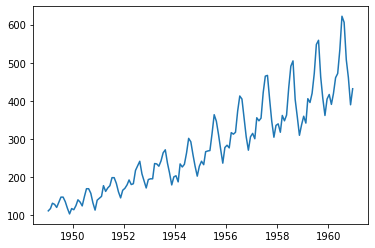

In [11]:
#assigning Passenger data to time series varable and plotting the TS
ts=data['#Passengers']
plt.plot(ts)

In [12]:
#from the above plot it is clear there is overall increase in the trend with some seasionality in it

<h2>Stationarity check- Rolling Statistic & Dickey Fuller Test</h2>

In [20]:
#function for Rolling Statistics and Dickey Fuller Test
def test_stationarity(timeseries):
    #rolling statistic
    rolmean=timeseries.rolling(window=52,center=False).mean()
    rolstd=timeseries.rolling(window=52,center=False).std()
    
    #plot rolling statistic
    orig = plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(rolmean,color='red',label='Rolling Mean')
    std=plt.plot(rolstd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    #Dickey Fuller Test
    print("Results of Dickey Fuller Test:")
    dftest=adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','P-value','#Lags Used',
                                        'Number of Observations Used' ])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    print(dfoutput)

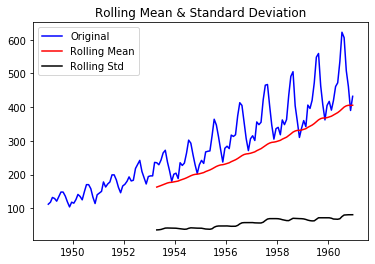

Results of Dickey Fuller Test:
Test Statistic                   0.815369
P-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [21]:
test_stationarity(data['#Passengers'])

In [22]:
# By observing the plot of rolling statistic plot and Dickey Value test results:
# WE infer that:
#Test statistic is more than critical value, and moving average is not constant over time. so Null Hypothesis of Dickey Fuller Test
# canot be rejected. This show that timeseries is not Stationary.


<h2>Decomposing the data</h2>

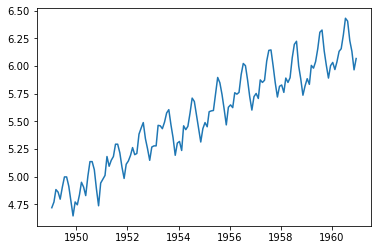

In [23]:
#plot moving average
#transforming series using log decomposition
ts_log=np.log(ts)
plt.plot(ts_log)

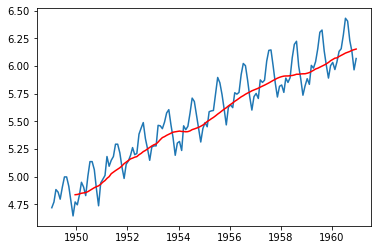

In [25]:
#initialize movingAverage & movingSTD variables
movingAverage=ts_log.rolling(window=12).mean()
movingSTD=ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(movingAverage,color='red')
#plt.plot(movingSTD,color='green')

In [27]:
ts_log_mv_diff=ts_log-movingAverage
ts_log_mv_diff.head(12)
ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(12)

Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
1950-05-15   -0.027529
1950-06-15    0.139881
1950-07-15    0.260184
1950-08-15    0.248635
1950-09-15    0.162937
1950-10-15   -0.018578
1950-11-15   -0.180379
Name: #Passengers, dtype: float64

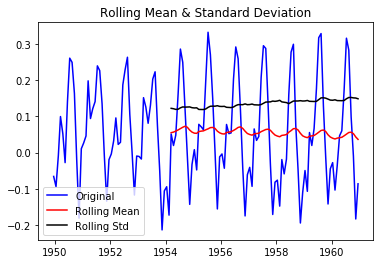

Results of Dickey Fuller Test:
Test Statistic                  -3.162908
P-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [28]:
test_stationarity(ts_log_mv_diff)

In [29]:
#By observing the Rolling statistic plot and Dickey fuller test results,
#shows that Test Statistic< Critical Value , therefore we can reject the Null Hypothesis.
#This series is stationary

<h2>ARIMA Model</h2>

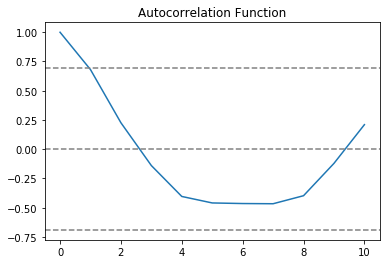

In [32]:
#plot acf
plt.plot(np.arange(0,11),acf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

In [ ]:
#the acf curve crosses the upper confidence value when the lag value between 0 and 1. 
#thus the optimal value of q must be 0 or 1

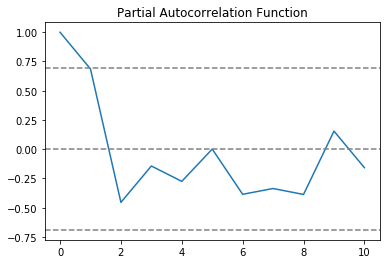

In [33]:
#plot pacf
plt.plot(np.arange(0,11),pacf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

In [ ]:
#pacf curve drops to 0 between lag values 1 and 2. thus the optimal value of p is 1 or 2.5

Text(0.5, 1.0, 'RSS: nan')

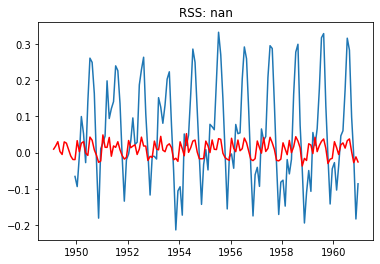

In [34]:
model=ARIMA(ts_log,order=(1,1,0))
results_ARIMA=model.fit(disp=-1)
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues[1:]-ts_log_mv_diff)**2))

In [37]:
#model predictions:
prdictions_ARIMA_diff=pd.Series(results_ARIMA.fittedvalues,copy=True)
prdictions_ARIMA_diff.head()

Month
1949-02-15    0.009676
1949-03-15    0.018164
1949-04-15    0.030130
1949-05-15    0.003154
1949-06-15   -0.005039
dtype: float64

In [38]:
# not bthe 1st month, we took a lag by 1. way to convert is

In [39]:
#find cummulitive sum
prdictions_ARIMA_diff_cummsum=prdictions_ARIMA_diff.cumsum()
prdictions_ARIMA_diff_cummsum.head()

Month
1949-02-15    0.009676
1949-03-15    0.027839
1949-04-15    0.057969
1949-05-15    0.061123
1949-06-15    0.056084
dtype: float64

In [40]:
#add them to base numbers and add differences to it
prdictions_ARIMA_log=pd.Series(ts_log.ix[0],index=ts_log.index)
prdictions_ARIMA_log=prdictions_ARIMA_log.add(prdictions_ARIMA_diff_cummsum,fill_value=0)
prdictions_ARIMA_log.head()


Month
1949-01-15    4.718499
1949-02-15    4.728175
1949-03-15    4.746338
1949-04-15    4.776468
1949-05-15    4.779622
dtype: float64

Text(0.5, 1.0, 'RMSE: 52.1841')

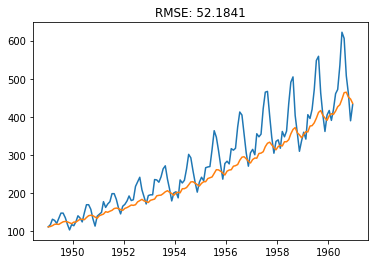

In [45]:
prdictions_ARIMA =np.exp(prdictions_ARIMA_log)
plt.plot(ts)
plt.plot(prdictions_ARIMA)
plt.title('RMSE: %.4f'%np.sqrt(sum((prdictions_ARIMA-ts)**2)/len(ts)))

In [ ]:
#orange curve is our predictions with RMSE: 52.1841
#While our model is good at predicting trend but fails in capturing seasonality. 